Data loaded successfully.

=== Basic Data Information ===
Number of samples: 3276
Number of features: 10

Columns: ['Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Organic_carbon', 'Chloramine_Sulfate_ratio', 'Organic_Trihalo_ratio', 'log_Solids', 'ph_squared', 'Solids_bins', 'Potability']

Data types:
 Hardness                    float64
Solids                      float64
Chloramines                 float64
Sulfate                     float64
Organic_carbon              float64
Chloramine_Sulfate_ratio    float64
Organic_Trihalo_ratio       float64
log_Solids                  float64
ph_squared                  float64
Solids_bins                 float64
Potability                    int64
dtype: object

=== Missing Values ===
Series([], dtype: int64)

=== Target Variable Distribution (Potability) ===
Potability
0    0.60989
1    0.39011
Name: proportion, dtype: float64

=== Basic Statistics ===
          Hardness        Solids  Chloramines      Sulfate  Organic_carbon  \
count  327

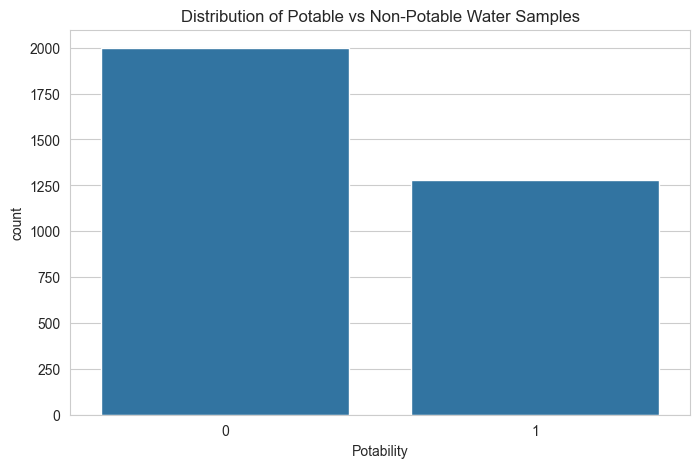

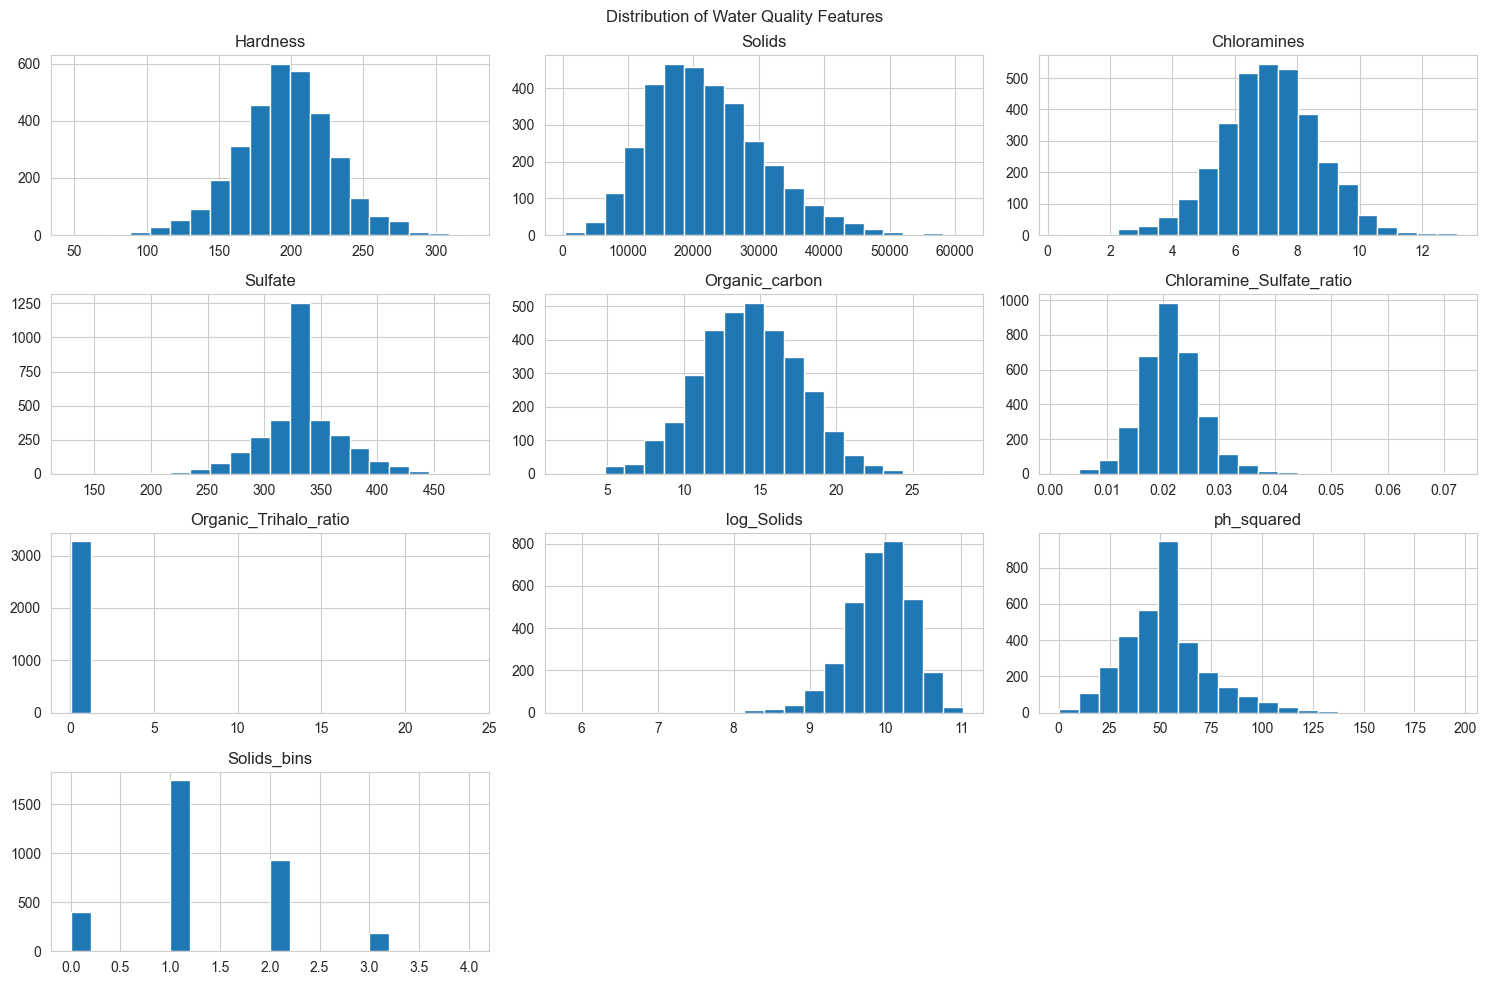

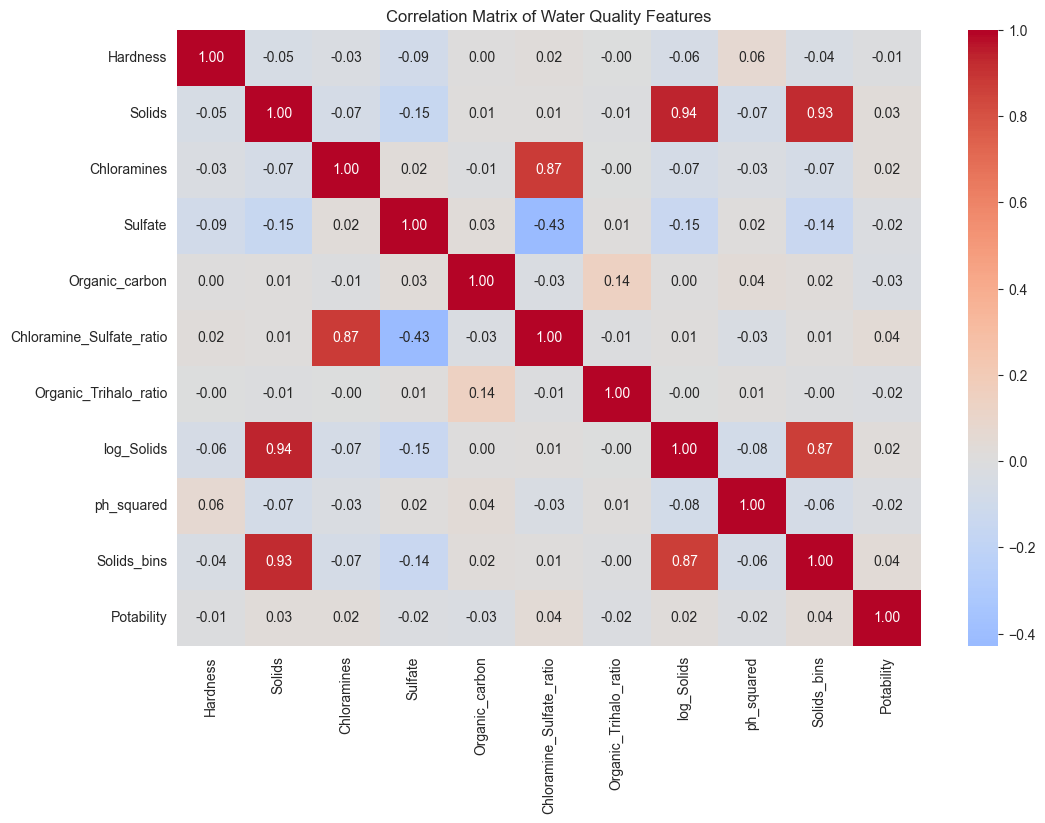

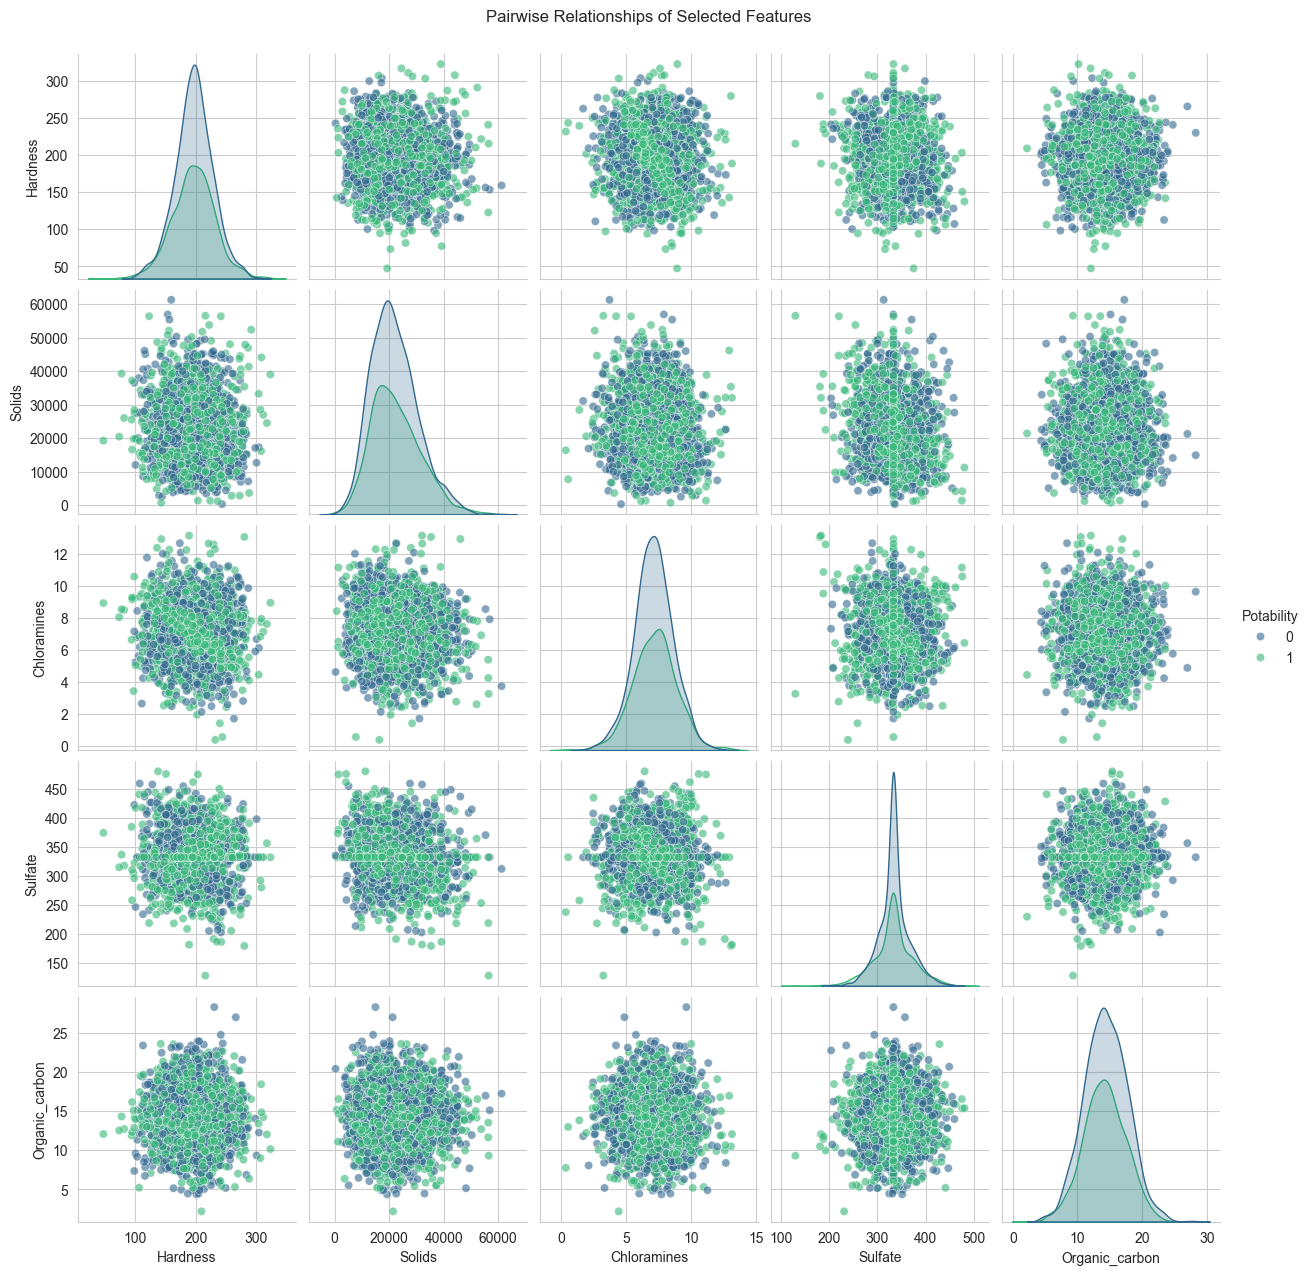


=== Outlier Detection ===
Hardness: 18 outliers (0.55%)
Solids: 20 outliers (0.61%)
Chloramines: 20 outliers (0.61%)
Sulfate: 34 outliers (1.04%)
Organic_carbon: 4 outliers (0.12%)
Chloramine_Sulfate_ratio: 29 outliers (0.89%)
Organic_Trihalo_ratio: 2 outliers (0.06%)
log_Solids: 33 outliers (1.01%)
ph_squared: 36 outliers (1.10%)
Solids_bins: 17 outliers (0.52%)
Processed data saved to processed_water_quality.csv


C:\Users\nigus\AppData\Local\Temp\ipykernel_4128\1015663874.py:114: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  self.categorical_features = [col for col in df.columns if pd.api.types.is_categorical_dtype(df[col])]


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

class WaterQualityPreprocessor:
    def __init__(self, scaling='standard'):
        """
        Initialize the preprocessor with optional scaling method.
        
        Args:
            scaling (str): 'standard' (default) or 'minmax' scaling
        """
        self.scaling = scaling
        self.preprocessor = None
        self.numerical_features = None
        self.categorical_features = None
    
    def load_data(self, filepath):
        """Load the dataset from a CSV file"""
        df = pd.read_csv(filepath)
        print("Data loaded successfully.")
        return df
    
    def explore_data(self, df):
        """Perform initial data exploration"""
        print("\n=== Basic Data Information ===")
        print(f"Number of samples: {len(df)}")
        print(f"Number of features: {len(df.columns) - 1}")  # excluding target
        print("\nColumns:", df.columns.tolist())
        print("\nData types:\n", df.dtypes)
        
        # Missing values analysis
        print("\n=== Missing Values ===")
        missing_values = df.isnull().sum()
        print(missing_values[missing_values > 0])
        
        # Target variable distribution
        if 'Potability' in df.columns:
            print("\n=== Target Variable Distribution (Potability) ===")
            print(df['Potability'].value_counts(normalize=True))
        
        # Basic statistics
        print("\n=== Basic Statistics ===")
        print(df.describe())
        
        return df
    
    def visualize_data(self, df):
        """Create exploratory visualizations"""
        # Set style
        sns.set_style("whitegrid")
        
        # Target distribution
        if 'Potability' in df.columns:
            plt.figure(figsize=(8, 5))
            sns.countplot(x='Potability', data=df)
            plt.title("Distribution of Potable vs Non-Potable Water Samples")
            plt.show()
        
        # Distribution of numerical features
        numerical_features = [col for col in df.columns if col != 'Potability' and pd.api.types.is_numeric_dtype(df[col])]
        df[numerical_features].hist(bins=20, figsize=(15, 10))
        plt.suptitle("Distribution of Water Quality Features")
        plt.tight_layout()
        plt.show()
        
        # Correlation matrix
        plt.figure(figsize=(12, 8))
        corr_matrix = df.corr()
        sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0)
        plt.title("Correlation Matrix of Water Quality Features")
        plt.show()
        
        # Pairplot for selected features (first 5 numerical features for performance)
        if len(numerical_features) > 5:
            selected_features = numerical_features[:5]
            if 'Potability' in df.columns:
                selected_features += ['Potability']
            sns.pairplot(df[selected_features], hue='Potability' if 'Potability' in df.columns else None, 
                        palette='viridis', plot_kws={'alpha': 0.6})
            plt.suptitle("Pairwise Relationships of Selected Features", y=1.02)
            plt.show()
    
    def detect_outliers(self, df, threshold=3):
        """Detect outliers using Z-score method"""
        numerical_features = [col for col in df.columns if pd.api.types.is_numeric_dtype(df[col]) and col != 'Potability']
        
        outlier_info = {}
        for feature in numerical_features:
            z_scores = np.abs((df[feature] - df[feature].mean()) / df[feature].std())
            outliers = z_scores > threshold
            outlier_info[feature] = {
                'count': outliers.sum(),
                'percentage': outliers.mean() * 100
            }
        
        print("\n=== Outlier Detection ===")
        for feature, info in outlier_info.items():
            print(f"{feature}: {info['count']} outliers ({info['percentage']:.2f}%)")
        
        return outlier_info
    
    def create_preprocessor(self, df):
        """Create a preprocessing pipeline"""
        # Identify feature types
        self.numerical_features = [col for col in df.columns if pd.api.types.is_numeric_dtype(df[col]) and col != 'Potability']
        self.categorical_features = [col for col in df.columns if pd.api.types.is_categorical_dtype(df[col])]
        
        # Numerical preprocessing pipeline
        numerical_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler() if self.scaling == 'standard' else MinMaxScaler())
        ])
        
        # Create column transformer
        self.preprocessor = ColumnTransformer(
            transformers=[
                ('num', numerical_transformer, self.numerical_features)
            ])
        
        return self.preprocessor
    
    def preprocess_data(self, df):
        """Preprocess the entire dataset"""
        if self.preprocessor is None:
            self.create_preprocessor(df)
        
        # Separate features and target if exists
        if 'Potability' in df.columns:
            X = df.drop('Potability', axis=1)
            y = df['Potability']
        else:
            X = df
            y = None
        
        # Apply preprocessing
        X_processed = self.preprocessor.fit_transform(X)
        
        # Convert back to DataFrame
        processed_df = pd.DataFrame(X_processed, columns=self.numerical_features)
        
        # Add back target if it exists
        if y is not None:
            processed_df['Potability'] = y.values
        
        return processed_df
    
    def save_processed_data(self, df, filepath):
        """Save processed data to CSV"""
        df.to_csv(filepath, index=False)
        print(f"Processed data saved to {filepath}")

# Example usage
if __name__ == "__main__":
    # Initialize preprocessor
    preprocessor = WaterQualityPreprocessor(scaling='standard')
    
    # Load data
    df = preprocessor.load_data('C:/Users/nigus/Desktop/AI-Group-3/Data/water_quality.csv')
    
    # Explore data
    preprocessor.explore_data(df)
    
    # Visualize data
    preprocessor.visualize_data(df)
    
    # Detect outliers
    preprocessor.detect_outliers(df)
    
    # Create and apply preprocessing
    preprocessor.create_preprocessor(df)
    processed_df = preprocessor.preprocess_data(df)
    
    # Save processed data
    preprocessor.save_processed_data(processed_df, 'processed_water_quality.csv')

=== Dataset Overview ===
Shape: (3276, 11) (Rows, Columns)

First 5 rows:


,Hardness,Solids,Chloramines,Sulfate,Organic_carbon,Chloramine_Sulfate_ratio,Organic_Trihalo_ratio,log_Solids,ph_squared,Solids_bins,Potability
0,204.890455,20791.318981,7.300212,368.516441,10.379783,0.019810,0.119320,9.942339,49.515880,1.0,0
1,129.422921,18630.057858,6.635246,333.073546,15.180013,0.019921,0.269488,9.832585,13.809251,1.0,0
2,224.236259,19909.541732,9.275884,333.073546,16.868637,0.027849,0.253969,9.899005,65.595813,1.0,0
3,214.373394,22018.417441,8.059332,356.886136,18.436524,0.022582,0.183737,9.999680,69.168595,1.0,0
4,181.101509,17978.986339,6.546600,310.135738,11.558279,0.021109,0.361219,9.797015,82.668527,1.0,0



Data Types:
Hardness                    float64
Solids                      float64
Chloramines                 float64
Sulfate                     float64
Organic_carbon              float64
Chloramine_Sulfate_ratio    float64
Organic_Trihalo_ratio       float64
log_Solids                  float64
ph_squared                  float64
Solids_bins                 float64
Potability                    int64
dtype: object

Missing Values:
Hardness                    0
Solids                      0
Chloramines                 0
Sulfate                     0
Organic_carbon              0
Chloramine_Sulfate_ratio    0
Organic_Trihalo_ratio       0
log_Solids                  0
ph_squared                  0
Solids_bins                 0
Potability                  0
dtype: int64


C:\Users\nigus\AppData\Local\Temp\ipykernel_4128\31324612.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Potability', data=df, palette="viridis")


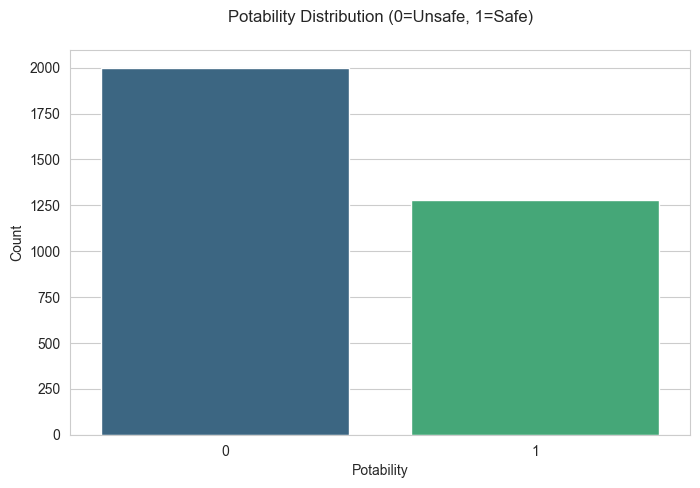


Potability Distribution (%):
Potability
0    61.0
1    39.0
Name: proportion, dtype: float64


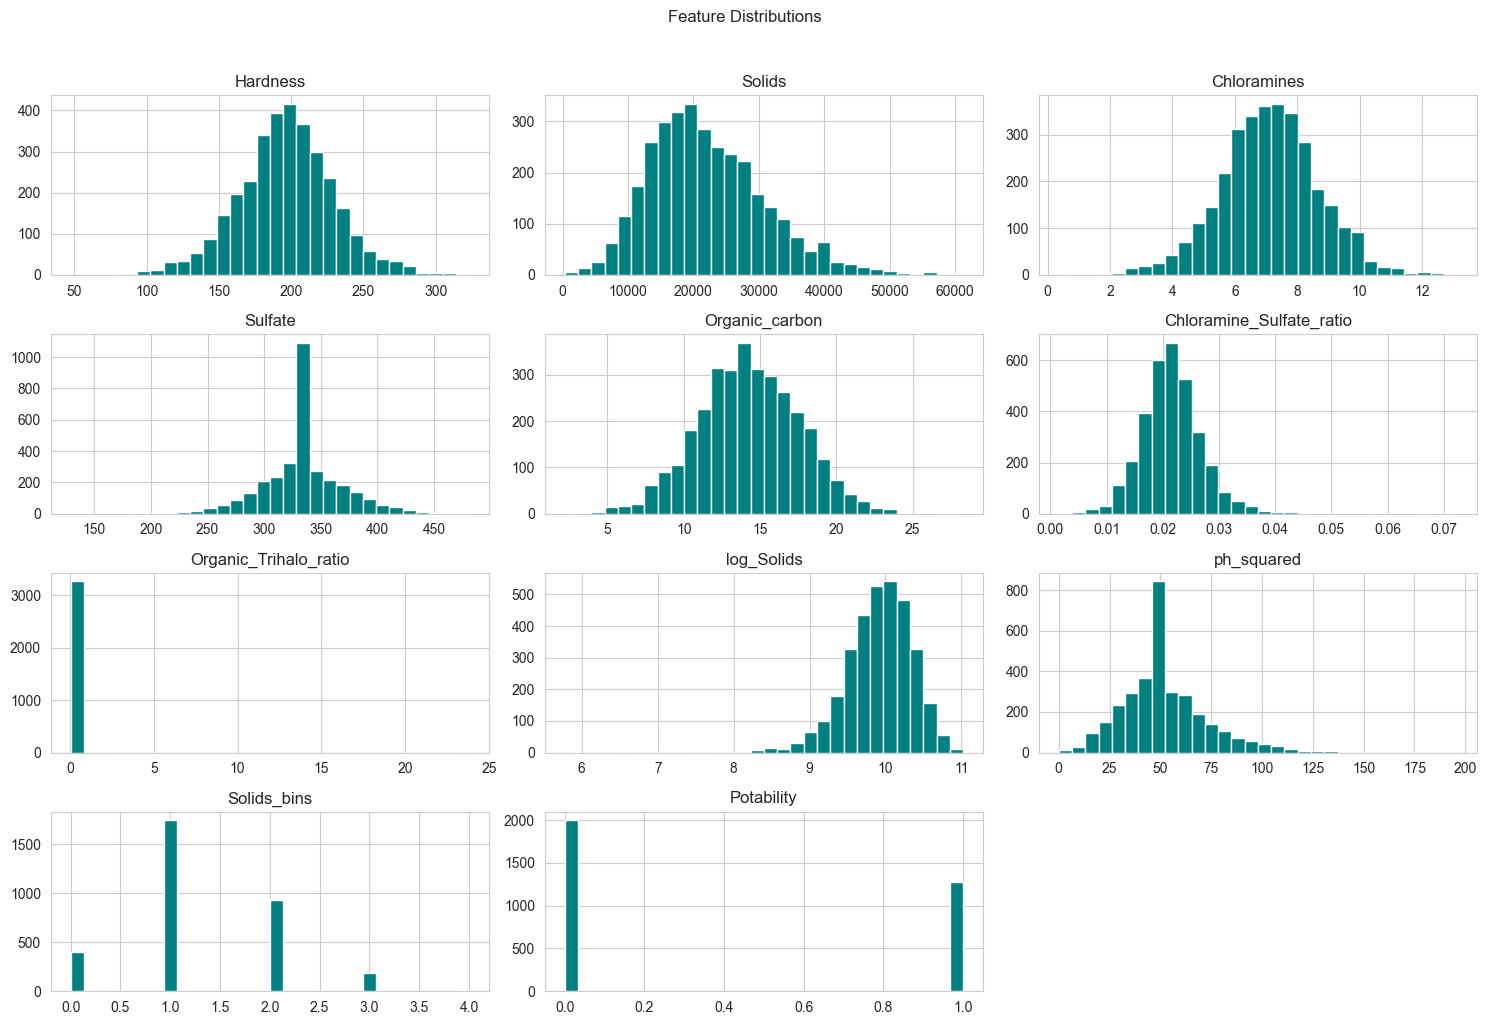

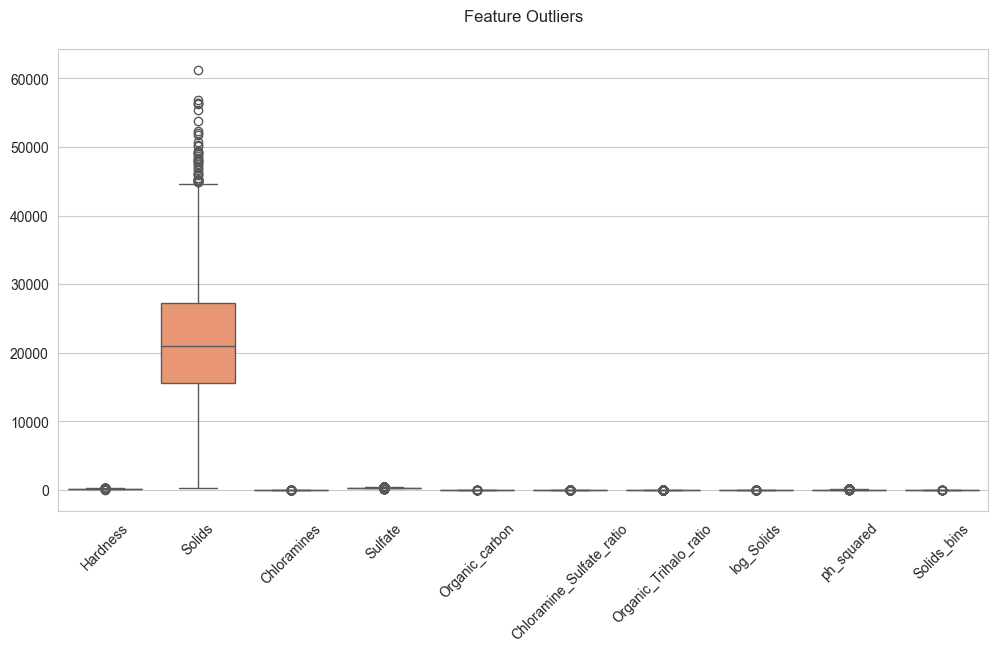

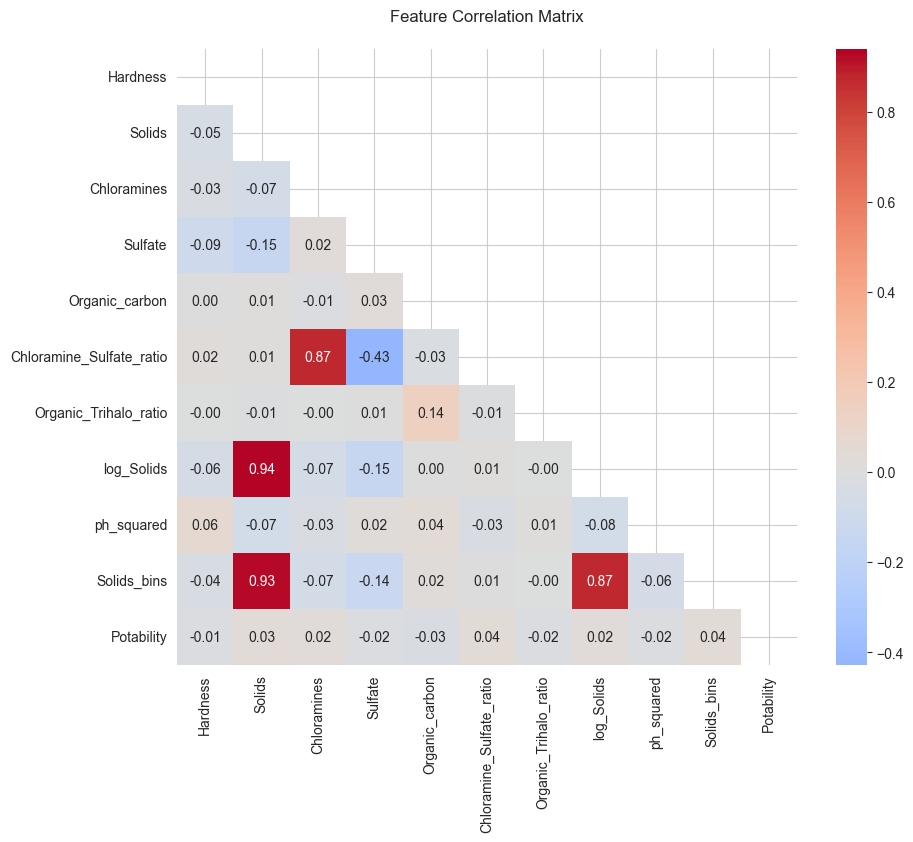

ValueError: Could not interpret value `ph` for `y`. An entry with this name does not appear in `data`.

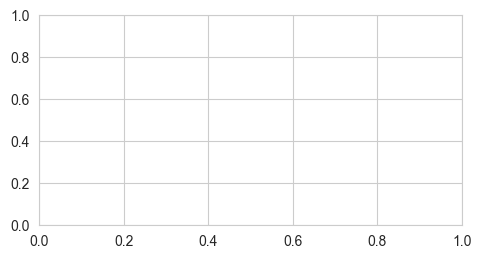

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#data visualization and explanatory analysis
# Load dataset
df = pd.read_csv("C:/Users/nigus/Desktop/AI-Group-3/Data/water_quality.csv")

# ======================
# 1. DATA OVERVIEW
# ======================
print("=== Dataset Overview ===")
print(f"Shape: {df.shape} (Rows, Columns)")
print("\nFirst 5 rows:")
display(df.head())

print("\nData Types:")
print(df.dtypes)

print("\nMissing Values:")
print(df.isnull().sum())

# Fill missing values with median (robust to outliers)
for col in df.columns:
    if df[col].isnull().sum() > 0:
        median_val = df[col].median()
        df[col] = df[col].fillna(median_val)
        print(f"Filled '{col}' with median: {median_val:.2f}")

# ======================
# 2. TARGET VARIABLE ANALYSIS
# ======================
plt.figure(figsize=(8,5))
sns.countplot(x='Potability', data=df, palette="viridis")
plt.title("Potability Distribution (0=Unsafe, 1=Safe)", pad=20)
plt.xlabel("Potability")
plt.ylabel("Count")
plt.show()

print("\nPotability Distribution (%):")
print(df['Potability'].value_counts(normalize=True).mul(100).round(1))

# ======================
# 3. FEATURE DISTRIBUTIONS
# ======================
# Histograms
df.hist(bins=30, figsize=(15,10), color='teal')
plt.suptitle("Feature Distributions", y=1.02)
plt.tight_layout()
plt.show()

# Boxplots for outlier detection
plt.figure(figsize=(12,6))
sns.boxplot(data=df.drop('Potability', axis=1), palette="Set2")
plt.title("Feature Outliers", pad=20)
plt.xticks(rotation=45)
plt.show()

# ======================
# 4. CORRELATION ANALYSIS
# ======================
# Heatmap
plt.figure(figsize=(10,8))
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, cmap="coolwarm", center=0, fmt=".2f")
plt.title("Feature Correlation Matrix", pad=20)
plt.show()

# ======================
# 5. FEATURE-TARGET RELATIONSHIPS
# ======================
# Violin plots for key features
key_features = ['ph', 'Hardness', 'Solids', 'Chloramines']
plt.figure(figsize=(12,6))
for i, feature in enumerate(key_features, 1):
    plt.subplot(2,2,i)
    sns.violinplot(x='Potability', y=feature, data=df, palette="viridis")
    plt.title(f"{feature} vs Potability")
plt.tight_layout()
plt.show()

# ======================
# 6. PAIRWISE RELATIONSHIPS
# ======================
sns.pairplot(df[['ph','Hardness','Solids','Potability']], 
             hue='Potability', 
             palette="viridis",
             plot_kws={'alpha':0.6})
plt.suptitle("Pairwise Feature Relationships", y=1.02)
plt.show()

# ======================
# 7. DISTRIBUTION COMPARISON
# ======================
# KDE plots for safe vs unsafe water
plt.figure(figsize=(12,8))
for i, col in enumerate(df.columns[:-1], 1):
    plt.subplot(3,3,i)
    sns.kdeplot(data=df, x=col, hue='Potability', fill=True, palette=["red","green"])
    plt.title(f"{col} Distribution")
plt.tight_layout()
plt.show()

In [6]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

def load_and_prepare_data(filepath):
    """Load the dataset and perform initial preparation"""
    df = pd.read_csv(filepath)
    
    # Display basic info
    print("Initial Data Info:")
    print(df.info())
    print("\nMissing values per column:")
    print(df.isnull().sum())
    
    return df

def handle_missing_values(df):
    """Handle missing values in the dataset"""
    # Separate features and target
    X = df.drop('Potability', axis=1)
    y = df['Potability']
    
    # Impute missing values - median for numerical features
    num_features = X.select_dtypes(include=np.number).columns.tolist()
    imputer = SimpleImputer(strategy='median')
    X[num_features] = imputer.fit_transform(X[num_features])
    
    return X, y

def create_new_features(X):
    """Create new engineered features"""
    # Feature interactions
    X['Hardness_Solids_ratio'] = X['Hardness'] / (X['Solids'] + 1e-6)
    X['Chloramine_Sulfate_ratio'] = X['Chloramines'] / (X['Sulfate'] + 1e-6)
    X['Organic_Trihalo_ratio'] = X['Organic_carbon'] / (X['Trihalomethanes'] + 1e-6)
    
    # Feature transformations
    X['log_Solids'] = np.log1p(X['Solids'])
    X['sqrt_Conductivity'] = np.sqrt(X['Conductivity'])
    X['ph_squared'] = X['ph'] ** 2
    
    # Binning continuous variables
    X['Hardness_bins'] = pd.cut(X['Hardness'], bins=5, labels=False)
    X['Solids_bins'] = pd.cut(X['Solids'], bins=5, labels=False)
    
    return X

def feature_selection(X, y):
    """Select most important features"""
    # Select top 10 features based on ANOVA F-value
    selector = SelectKBest(score_func=f_classif, k=10)
    X_selected = selector.fit_transform(X, y)
    
    # Get selected feature names
    selected_features = X.columns[selector.get_support()]
    print("\nSelected Features:")
    print(selected_features)
    
    return pd.DataFrame(X_selected, columns=selected_features), selected_features

def create_preprocessing_pipeline(selected_features):
    """Create preprocessing pipeline for selected features"""
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, selected_features)
        ])
    
    return preprocessor

def main():
    # Load data
    df = load_and_prepare_data("C:/Users/nigus/Desktop/AI-Group-3/Data/water_quality.csv")
    
    # Handle missing values
    X, y = handle_missing_values(df)
    
    # Feature engineering
    X_engineered = create_new_features(X)
    
    # Feature selection
    X_selected, selected_features = feature_selection(X_engineered, y)
    
    # Create preprocessing pipeline
    preprocessor = create_preprocessing_pipeline(selected_features)
    
    # You can now use preprocessor in your model pipeline
    # Example: 
    # model = Pipeline(steps=[('preprocessor', preprocessor),
    #                        ('classifier', RandomForestClassifier())])
    
    # Save processed data for modeling
    processed_data = pd.concat([X_selected, y], axis=1)
    processed_data.to_csv("C:/Users/nigus/Desktop/AI-Group-3/Data/water_quality.csv", index=False)
    print("\nProcessed data saved to 'water_quality_processed.csv'")

if __name__ == "__main__":
    main()

Initial Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Hardness                  3276 non-null   float64
 1   Solids                    3276 non-null   float64
 2   Chloramines               3276 non-null   float64
 3   Sulfate                   3276 non-null   float64
 4   Organic_carbon            3276 non-null   float64
 5   Chloramine_Sulfate_ratio  3276 non-null   float64
 6   Organic_Trihalo_ratio     3276 non-null   float64
 7   log_Solids                3276 non-null   float64
 8   ph_squared                3276 non-null   float64
 9   Solids_bins               3276 non-null   float64
 10  Potability                3276 non-null   int64  
dtypes: float64(10), int64(1)
memory usage: 281.7 KB
None

Missing values per column:
Hardness                    0
Solids                      0
Chloramines  

KeyError: 'Trihalomethanes'